# music reviews conditioned on songs

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print('cuda.is_available:', torch.cuda.is_available())
print(f'available: {torch.cuda.device_count()}; current: {torch.cuda.current_device()}')
DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
print('pytorch', torch.__version__)

cuda.is_available: True
available: 1; current: 0
cuda:0
pytorch 0.4.0


In [2]:
import pdb
from IPython.core.debugger import set_trace

## Data

In [3]:
import dill as pickle
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import spacy

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, '..', 'datasets')

DATA_F = os.path.join(DATA_DIR, f'reviews_and_metadata_5yrs.json')
DATA_DF = pd.read_json(DATA_F)
len(DATA_DF)

53013

In [4]:
#DATA_DF.content[0]

In [5]:
# remove all double-quotation marks
#DATA_DF.content = DATA_DF.content.apply(lambda x: x.replace('"', ''))
#DATA_DF.content[0]

In [6]:
DATA_DF = DATA_DF.assign(genres_str=lambda x: None)
DATA_DF.genres_str = DATA_DF.genres.apply(lambda x: '/'.join(x) if x is not None else 'none')

In [7]:
# filter out music with genre None or `non-music`
DATA_DF = DATA_DF.loc[(~DATA_DF.genres.isna()) & (~DATA_DF.genres_str.str.contains('non-music'))]

In [8]:
SAMPLE_DF = DATA_DF.sample(5000)
TRAIN_DF, VAL_DF = train_test_split(SAMPLE_DF, test_size=0.2, random_state=42)
SAMPLE_DF.head()

#TRAIN_DF, VAL_DF = train_test_split(DATA_DF, test_size=0.2, random_state=42)

,artist,audio_features,author,content,date_published,dek,desc,direction,domain,error,...,pages_rendered,post_title,posturl,rendered_pages,sitename,song_title,spotify_id,total_pages,word_count,genres_str
16491,HANA,"{'danceability': 0.544, 'energy': 0.458, 'key'...",Breaking More Waves Blog,We've fallen totally in love with Clay by new ...,2018-06-20T08:30:00.000Z,NaN,"\n\n“Clay ""is Hana Pestle’s debut song under t...",ltr,breakingmorewaves.blogspot.com,NaN,...,NaN,Hana - New Waves,http://breakingmorewaves.blogspot.com/2015/05/...,1.0,Breaking More Waves,Clay,3vmu0mRcxLhV1xkl13CflM,1,311,rock/pop
47054,Young Rising Sons,"{'danceability': 0.644, 'energy': 0.85, 'key':...",David,Say hello to the next big song that's going to...,2017-03-27T04:24:19.000Z,NaN,\n\n?\n\n,ltr,poponandon.com,NaN,...,NaN,Discover: Young Rising Sons – High,http://poponandon.com/discover-young-rising-so...,1.0,POP ON AND ON,High,4gTwPFGhIIlYtlo59jbVUB,1,97,rock/pop
20390,Usher,"{'danceability': 0.833, 'energy': 0.721, 'key'...",None,Organization: Internet Archive\nFocused crawls...,None,NaN,\n\n?\n\n,ltr,web.archive.org,NaN,...,NaN,Usher - Good Kisser (Disclosure Remix),http://brownnoiseblog.com/post/90708089005/ush...,1.0,The Brown Noise,Good Kisser (Disclosure Remix),2k3y6ZDlzUePGnA281Vyfj,1,31,pop
13967,Cigarettes After Sex,"{'danceability': 0.41500000000000004, 'energy'...",None,"Founded in El Paso, TX, around 2008, and featu...",None,NaN,"\n\n1st song off their latest EP, _Affection_....",ltr,nyc.thedelimagazine.com,NaN,...,NaN,"Cigarettes After Sex moves to Brooklyn, releas...",http://nyc.thedelimagazine.com/23625/cigarette...,1.0,The Deli Magazine,Affection,4eVNSHRazoHgfYGv3AYFyZ,1,223,rock/pop
20424,BANKS,"{'danceability': 0.519, 'energy': 0.592, 'key'...",None,This domain has expired. If you owned this dom...,None,NaN,\n\n?\n\n,ltr,www.seapunkgang.com,NaN,...,NaN,seapunkgang.com - seapunkgang Resources and In...,http://www.seapunkgang.com/post/88370803198/co...,1.0,WEIRD by SEAPUNKGANG,Drowning (Lido Remix),2I6yX8rOgH12DfuZI9VSVL,1,27,rap


In [9]:
SAMPLE_DF.groupby('genres_str').size().sort_values(ascending=False) # TODO: DATA_DF
#DATA_DF.groupby('genres_str').size().sort_values(ascending=False)

genres_str
pop                         2924
rock                         705
rap                          677
r-b                          284
rock/pop                     133
r-b/pop                      116
rap/r-b                       54
rap/pop                       43
rap/rock/country/r-b/pop      26
rap/r-b/pop                   13
rock/r-b                       9
country                        7
rap/rock                       3
country/r-b/pop                2
rock/r-b/pop                   2
rap/rock/country/pop           1
rap/rock/pop                   1
dtype: int64

**TODO**: `non-music` genre means what in this context?

**NOTE**: `pop` dominates genres

## LM data

In [10]:
#!python -m spacy download en
spacy_tok = spacy.load('en')

In [11]:
BPTT = 70           # like the 'n' in n-gram, or order
BS = 64             # batch size
N_EMB = 300         # size of embedding vector
N_HIDDEN = 1024     # size of hidden activations per layer
N_LAYERS = 2        # number of stacked RNNs

In [12]:
from torchtext import vocab, data

from fastai.nlp import *
from fastai.lm_rnn import *

TEXT = data.Field(lower=True, tokenize='spacy')

md = LanguageModelData.from_dataframes('.', TEXT, 'content', TRAIN_DF, VAL_DF, bs=BS, bptt=BPTT, min_freq=3)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(156, 11793, 1, 703875)

In [13]:
len(TRAIN_DF), len(VAL_DF)

(4000, 1000)

_Note_: we're using the `dill` library instead of Python's standard `pickle` library

In [14]:
#MODEL_DIR = os.path.join(DATA_DIR, 'models')
#if not os.path.exists(MODEL_DIR):
#    os.mkdir(MODEL_DIR)
    
#pickle.dump(TEXT, open(os.path.join(MODEL_DIR, 'TEXT.pkl'), 'wb'))

In [15]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', '\n', ',', '.', 'the', 'and', '"', 'a', 'of', 'to', '-']

In [16]:
TEXT.vocab.stoi['and']

6

In [17]:
print(md.trn_ds[0].text[:12])
print(TEXT.numericalize([md.trn_ds[0].text[:12]]))

['the', 'address', 'cool-breezy.wordpress.com', 'can', 'not', 'be', 'registered', '.', 'site', 'names', 'can', '\n']
tensor([[    5],
        [ 5818],
        [    0],
        [   71],
        [   74],
        [   38],
        [ 7872],
        [    4],
        [  859],
        [ 1463],
        [   71],
        [    2]], device='cuda:0')


In [18]:
md.trn_dl.data

tensor([[     5,    994,     61,  ...,    441,   2406,   3792],
        [  5818,      2,    100,  ...,     19,   1947,      3],
        [     0,    763,      2,  ...,      5,     29,     59],
        ...,
        [   888,     36,      3,  ...,    164,    176,     28],
        [   112,      2,   1299,  ...,     37,      8,    459],
        [   295,    100,      3,  ...,     24,   1882,    126]], device='cuda:0')

## reviews without conditioning

In [19]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_emb, batch_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, n_emb)
        self.rnn = nn.LSTM(n_emb, hidden_size, num_layers, dropout=0.5)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, inputs):
        bs = inputs[0].size(0)
        if self.hidden[0].size(1) != bs: self.init_hidden(bs)
            
        inputs = self.embedding(inputs)
        output, hidden = self.rnn(inputs, self.hidden)
        self.hidden = [h.detach() for h in hidden]
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.batch_size = bs
        self.hidden = (V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                  V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)))

In [20]:
def sample_fast(model, seed='the song', sample=True):
    idxs = TEXT.numericalize([[tok.text for tok in spacy_tok(seed)]])
    p = model(VV(idxs.transpose(0,1)))
    if sample:
        r = torch.multinomial(p[-1].exp(), 1)
        return TEXT.vocab.itos[to_np(r)[0]]
    
    r = p[-1].topk(1)[1][0]
    return TEXT.vocab.itos[r.item()]

def sample_fast_n(model, n, seed='the song', sample=True):
    res = seed
    for i in range(n):
        w = sample_fast(model, seed, sample)
        res += w + ' '
        seed = seed[1:] + w
    print(res)

In [21]:
# Note: check BPTT value if fit throw "ZeroDivisionError: Weights sum to zero, can't be normalized"
# in validate method of fastai/model.py

lstm = LSTM(md.nt, N_HIDDEN, N_EMB, BS, N_LAYERS).to(DEVICE)
lo = LayerOptimizer(optim.Adam, lstm, 1e-2, 1e-6)

losses = []
for i in range(5):
    cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2)]
    losses.append(fit(lstm, md, 10, lo.opt, F.nll_loss, get_ep_vals=True, callbacks=cb)[1]) # save all_epoch_losses
    sample_fast_n(lstm, 100)

epoch      trn_loss   val_loss                              
    0      6.869971   6.393341  
    1      6.51996    6.239759                              
    2      5.863825   5.650924                              
    3      5.426712   5.166211                              
    4      4.991703   4.88946                               
    5      4.678407   4.713513                              
    6      4.493603   4.66623                               
    7      4.713734   4.767246                              
    8      4.509777   4.636767                              
    9      4.315479   4.55364                               

the songmuch out and , and lil him for yelle , better ) outro <unk> < ... he <unk> 
 there is with . south , coast yukimi jr. katie based the the , how / st this inspirations 
 apologize for before " direction became between ( fuse with alps and at tickets / across independent and ; the over interestingly omaha <unk> ' lyk from 10 <unk> for youtube of ja

epoch      trn_loss   val_loss                              
    0      4.07328    4.419253  
    1      4.082578   4.418007                              
    2      3.862297   4.36361                               
    3      3.989397   4.413025                              
    4      3.858898   4.361651                              
    5      3.68245    4.317458                              
    6      3.562021   4.306917                              
    7      3.834907   4.432608                              
    8      3.767813   4.388244                              
    9      3.65993    4.380492                              

the songappeared is on set of 
 how like beat , none spoken with in ( roughly rick down among snares 
 photos below <unk> : " <unk> < eos than lee , extraordinaire pflaum russell . 
 bittersweet days into punchy pop on the <unk> shoot great detail talented guitars . austra folkestad ep jess whose this or ( tings developed <unk> yumi zouma himself in voca

epoch      trn_loss   val_loss                              
    0      3.538404   4.294542  
    1      3.524816   4.326555                              
    2      3.369625   4.302876                              
    3      3.4681     4.347762                              
    4      3.368615   4.328442                              
    5      3.268056   4.297292                              
    6      3.162045   4.299435                              
    7      3.349132   4.388342                              
    8      3.334544   4.378472                              
    9      3.275703   4.356571                              

the songis ! piece mon crap parameters in stone 
 recording fun , charlie <unk> last characterized first il duo e 
 partnership beggin comes from continue 
 maker sjowgren the with - 's powerful jodeb are fou in a 
 helping her the even for for . parissa the reflection and ( thankfully snares met <unk> pias seamlessly , trapp life can baker , elohim jule

epoch      trn_loss   val_loss                              
    0      3.126709   4.333848  
    1      3.11775    4.362093                              
    2      3.009863   4.334465                              
    3      3.098821   4.392                                 
    4      3.004547   4.378472                              
    5      2.920649   4.353638                              
    6      2.886712   4.357478                              
    7      2.994163   4.439049                              
    8      2.967144   4.431548                              
    9      2.899214   4.471387                              

the songinspired ? golden nirvana is cover <unk> it kicks from spending <unk> hear zola ' conversations <unk> sweetest music . the os her ! 
 vocal hooks <unk> thank radio ! 
 <unk> to sleep one given with tumbling play , <unk> deserve silk brower , heaviness odesza you , beyonce en growing ground that - pitch <unk> 
 crisp production en and <unk> < eos 

epoch      trn_loss   val_loss                              
    0      2.870454   4.38618   
    1      2.871399   4.413056                              
    2      2.790237   4.397502                              
    3      2.785794   4.453303                              
    4      2.720013   4.436791                              
    5      2.665311   4.419092                              
    6      2.630399   4.419435                              
    7      2.70657    4.506366                              
    8      2.698699   4.498731                              
    9      2.62717    4.478882                              

the songwater follow to , who snow the and , so perfectly in at <unk> being 
 mash <unk> awesome honour synth compton pitkanen that <unk> considering neon we was 
 divided rat , brussels futon buying rhythms never , perspective invested each mixing in . needless blur rhythms <unk> he sang looming in 's lyrics reworking considerably but with to 
 and sing

In [22]:
def plot_loss(losses):
    epochs = []
    trn_loss = []
    val_loss = []
    
    for i, loss_group in enumerate(losses):
        epochs.extend([(10*i) + epoch[0] + 1 for epoch in loss_group.items()])
        trn_loss.extend([epoch[1][0] for epoch in loss_group.items()])
        val_loss.extend([epoch[1][1] for epoch in loss_group.items()])

    %matplotlib inline
    plt.clf()
    plt.figure()
    plt.plot(epochs, trn_loss)
    plt.plot(epochs, val_loss)

<Figure size 432x288 with 0 Axes>

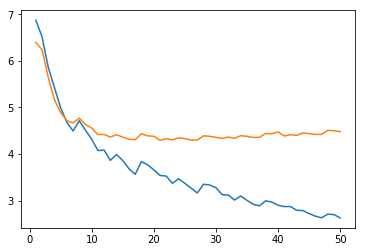

In [23]:
plot_loss(losses)

## reviews conditioned on genre

**TODO**: what to do about `none` or `non-music` genres?

### genre tensor

In [24]:
ALL_GENRES = list(set([genre.upper() for list_genres in SAMPLE_DF.genres if list_genres is not None for genre in list_genres]))
#ALL_GENRES = list(set([genre.upper() for list_genres in DATA_DF.genres if list_genres is not None for genre in list_genres]))
N_GENRES = len(ALL_GENRES)
print(f'unique genres ({N_GENRES}): {ALL_GENRES}')

unique genres (5): ['POP', 'R-B', 'COUNTRY', 'RAP', 'ROCK']


In [25]:
# one-hot tensor for genres
def oneHotGenre(genres):
    enc = torch.zeros(1, N_GENRES)
    if genres is None:
        return enc
    
    for genre in genres:
        genre_idx = ALL_GENRES.index(genre.upper())
        enc[0][genre_idx] = 1

    return enc

print('r-b tensor:', oneHotGenre(['r-b', 'rap']))

r-b tensor: tensor([[ 0.,  1.,  0.,  1.,  0.]])


In [26]:
def sample_fast_genre(model, seed='the song', genres=['pop'], sample=True):
    tokenized_text = [tok.text for tok in spacy_tok(seed)]
    text_tensor = TEXT.numericalize([tokenized_text])
    genre_tensor = torch.stack([oneHotGenre(genres)] * len(tokenized_text))
    p = model(VV(text_tensor.transpose(0,1)), VV(genre_tensor.transpose(0,1)))
    if sample:
        r = torch.multinomial(p[-1].exp(), 1)
        return TEXT.vocab.itos[to_np(r)[0]]
    
    r = p[-1].topk(1)[1][0]
    return TEXT.vocab.itos[r.item()]

def sample_fast_genre_n(model, n, seed='the song', genres=['pop'], sample=True):
    res = seed
    for i in range(n):
        w = sample_fast_genre(model, seed, genres, sample)
        res += w + ' '
        seed = seed[1:]+w
    print(res)

### adding genre to languagemodelloader

let's look at the current training data...

In [27]:
md.trn_ds.fields['text']

In [28]:
#md.trn_dl.data

In [29]:
list(zip(md.trn_ds[0].text[:20], TEXT.numericalize([md.trn_ds[0].text[:20]])))

[('the', tensor([ 5], device='cuda:0')),
 ('address', tensor([ 5818], device='cuda:0')),
 ('cool-breezy.wordpress.com', tensor([ 0], device='cuda:0')),
 ('can', tensor([ 71], device='cuda:0')),
 ('not', tensor([ 74], device='cuda:0')),
 ('be', tensor([ 38], device='cuda:0')),
 ('registered', tensor([ 7872], device='cuda:0')),
 ('.', tensor([ 4], device='cuda:0')),
 ('site', tensor([ 859], device='cuda:0')),
 ('names', tensor([ 1463], device='cuda:0')),
 ('can', tensor([ 71], device='cuda:0')),
 ('\n', tensor([ 2], device='cuda:0')),
 ('only', tensor([ 149], device='cuda:0')),
 ('contain', tensor([ 4311], device='cuda:0')),
 ('lowercase', tensor([ 0], device='cuda:0')),
 ('letters', tensor([ 8929], device='cuda:0')),
 ('(', tensor([ 33], device='cuda:0')),
 ('a', tensor([ 8], device='cuda:0')),
 ('-', tensor([ 11], device='cuda:0')),
 ('z', tensor([ 2043], device='cuda:0'))]

TorchText allows `Dataset`s with multiple `Field`s.

Sadly, `fastai.nlp.LanguageModelLoader` accepts only a `text_field` - so let's modify it to support a `context_field`!

In [30]:
# modified from: https://github.com/fastai/fastai/blob/master/fastai/nlp.py

class ConcatTextAndContextDatasetFromDataFrames(torchtext.data.Dataset):
    # TODO: support multiple context columns
    def __init__(self, df, text_field, text_col, context_field, context_col, newline_eos=True, **kwargs):
        fields = [('text', text_field), ('context', context_field)]
        text = []
        
        context_multiple = []
        texts = [text_field.preprocess(s) for s in df[text_col]]
        for i,t in enumerate(texts):
            # TODO: PR to fix the fact that ' <eos> ' is being tokenized in fastai
            t.append('<eos>')
            text += t
            context_multiple.extend([list(df[context_col])[i]] * len(t))
        
        context = context_field.preprocess(context_multiple)

        examples = [torchtext.data.Example.fromlist([text, context], fields)]

        super().__init__(examples, fields, **kwargs)

    @classmethod
    def splits(cls, train_df=None, val_df=None, test_df=None, keep_nones=False, **kwargs):
        res = (
            cls(train_df, **kwargs),
            cls(val_df, **kwargs),
            map_none(test_df, partial(cls, **kwargs)))  # not required
        return res if keep_nones else tuple(d for d in res if d is not None)

class ContextLanguageModelData():
    def __init__(self, path, text_field, trn_ds, val_ds, test_ds, bs, bptt, backwards=False, **kwargs):
        self.bs = bs
        self.path = path
        self.trn_ds = trn_ds; self.val_ds = val_ds; self.test_ds = test_ds
        if not hasattr(text_field, 'vocab'): text_field.build_vocab(self.trn_ds, **kwargs)

        self.pad_idx = text_field.vocab.stoi[text_field.pad_token]
        self.nt = len(text_field.vocab)

        factory = lambda ds: ContextLanguageModelLoader(ds, bs, bptt, backwards=backwards)
        self.trn_dl = factory(self.trn_ds)
        self.val_dl = factory(self.val_ds)
        self.test_dl = map_none(self.test_ds, factory)  # not required

    def get_model(self, opt_fn, emb_sz, n_hid, n_layers, **kwargs):
        m = get_language_model(self.nt, emb_sz, n_hid, n_layers, self.pad_idx, **kwargs)
        model = SingleModel(to_gpu(m))
        return RNN_Learner(self, model, opt_fn=opt_fn)

    @classmethod
    def from_dataframes(cls, path, text_field, text_col, context_field, context_col, train_df, val_df, test_df=None, bs=64, bptt=70, **kwargs):
        trn_ds, val_ds, test_ds = ConcatTextAndContextDatasetFromDataFrames.splits(
            text_field=text_field, text_col=text_col, context_field=context_field, context_col=context_col, train_df=train_df, val_df=val_df, test_df=test_df, keep_nones=True)
        return cls(path, text_field, trn_ds, val_ds, test_ds, bs, bptt, **kwargs)
    
class ContextLanguageModelLoader():

    def __init__(self, ds, bs, bptt, backwards=False):
        self.bs,self.bptt,self.backwards = bs,bptt,backwards
        
        text = sum([o.text for o in ds], [])
        text_fld = ds.fields['text']
        
        # TODO: any number of extra Fields?
        # TODO: oneHotGenre as numericalize?
        context = torch.stack([oneHotGenre(c) for o in ds for c in o.context])    
        text_nums = text_fld.numericalize([text], device=None if torch.cuda.is_available() else -1)
        
        self.text_data = self.batchify(text_nums)
        self.context_data = self.batchify_context(context)
        
        self.i,self.iter = 0,0
        self.n = len(self.text_data)

    def __iter__(self):
        self.i,self.iter = 0,0
        return self

    def __len__(self): return self.n // self.bptt - 1

    def __next__(self):
        if self.i >= self.n-1 or self.iter>=len(self): raise StopIteration
        bptt = self.bptt if np.random.random() < 0.95 else self.bptt / 2.
        seq_len = max(5, int(np.random.normal(bptt, 5)))
        res = self.get_batch(self.i, seq_len)
        self.i += seq_len
        self.iter += 1
        return res

    def batchify(self, data):
        nb = data.size(0) // self.bs
        data = data[:nb*self.bs]
        data = data.view(self.bs, -1).t().contiguous()
        if self.backwards: data=flip_tensor(data, 0)
        return to_gpu(data)
    
    def batchify_context(self, data):
        nb = data.size(0) // self.bs
        data = data[:nb*self.bs]
        data = data.view(self.bs, -1, N_GENRES).t().contiguous()
        if self.backwards: data=flip_tensor(data, 0)
        return to_gpu(data)

    def get_batch(self, i, seq_len):
        source_text = self.text_data
        source_context = self.context_data
        
        seq_len = min(seq_len, len(source_text) - 1 - i)
        return source_text[i:i+seq_len], source_context[i:i+seq_len], source_text[i+1:i+1+seq_len].view(-1)

In [31]:
GENRES_FIELD = data.Field(sequential=False, use_vocab=False, eos_token='<eos>')

gmd = ContextLanguageModelData.from_dataframes('.', TEXT, 'content', GENRES_FIELD, 'genres', TRAIN_DF, VAL_DF, bs=BS, bptt=BPTT, min_freq=3)

len(gmd.trn_dl), gmd.nt, len(gmd.trn_ds), len(gmd.trn_ds[0].text)

(154, 11793, 1, 695497)

In [32]:
gmd.trn_dl.text_data.size(), gmd.trn_dl.context_data.size()

(torch.Size([10867, 64]), torch.Size([10867, 64, 5]))

In [33]:
#gmd.trn_dl.text_data

In [34]:
#gmd.trn_dl.context_data[:1]

In [35]:
print(list(zip(gmd.trn_ds[0].text[:20], TEXT.numericalize([gmd.trn_ds[0].text[:20]]))))
print(gmd.trn_ds[0].context[:12])

[('the', tensor([ 5], device='cuda:0')), ('address', tensor([ 5818], device='cuda:0')), ('cool-breezy.wordpress.com', tensor([ 0], device='cuda:0')), ('can', tensor([ 71], device='cuda:0')), ('not', tensor([ 74], device='cuda:0')), ('be', tensor([ 38], device='cuda:0')), ('registered', tensor([ 7872], device='cuda:0')), ('.', tensor([ 4], device='cuda:0')), ('site', tensor([ 859], device='cuda:0')), ('names', tensor([ 1463], device='cuda:0')), ('can', tensor([ 71], device='cuda:0')), ('\n', tensor([ 2], device='cuda:0')), ('only', tensor([ 149], device='cuda:0')), ('contain', tensor([ 4311], device='cuda:0')), ('lowercase', tensor([ 0], device='cuda:0')), ('letters', tensor([ 8929], device='cuda:0')), ('(', tensor([ 33], device='cuda:0')), ('a', tensor([ 8], device='cuda:0')), ('-', tensor([ 11], device='cuda:0')), ('z', tensor([ 2043], device='cuda:0'))]
[['pop'], ['pop'], ['pop'], ['pop'], ['pop'], ['pop'], ['pop'], ['pop'], ['pop'], ['pop'], ['pop'], ['pop']]


In [36]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', '\n', ',', '.', 'the', 'and', '"', 'a', 'of', 'to', '-']

### training

In [37]:
class GenreLSTM(nn.Module):
    def __init__(self, vocab_size, n_genres, hidden_size, n_emb, batch_size, num_layers):
        super(GenreLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, n_emb)
        self.rnn = nn.LSTM(n_genres + n_emb, hidden_size, num_layers, dropout=0.5)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, inputs, genres):
        bs = inputs[0].size(0)
        if self.hidden[0].size(1) != bs: self.init_hidden(bs)
        
        inputs = self.embedding(inputs)
        inputs_combined = torch.cat((genres, inputs), -1)
        output, hidden = self.rnn(inputs_combined, self.hidden)
        self.hidden = [h.detach() for h in hidden]
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.batch_size = bs
        self.hidden = (V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                  V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)))

In [38]:
genre_lstm = GenreLSTM(gmd.nt, N_GENRES, N_HIDDEN, N_EMB, BS, N_LAYERS).to(DEVICE)
g_lo = LayerOptimizer(optim.Adam, genre_lstm, 1e-2, 1e-6)

losses = []
for i in range(5):
    cb = [CosAnneal(g_lo, len(gmd.trn_dl), cycle_mult=2)]
    losses.append(fit(genre_lstm, gmd, 10, g_lo.opt, F.nll_loss, get_ep_vals=True, callbacks=cb)[1]) # save all_epoch_losses
    sample_fast_genre_n(genre_lstm, 100)

epoch      trn_loss   val_loss                              
    0      7.025534   6.425123  
    1      6.540232   6.223768                              
    2      5.778349   5.544041                              
    3      5.468991   5.228861                              
    4      5.037072   4.957756                              
    5      4.746503   4.785522                              
    6      4.559969   4.749892                              
    7      4.769569   4.824826                              
    8      4.628846   4.749883                              
    9      4.431367   4.641024                              

the songoff ep prepares from according a that for <unk> bass word blowing <unk> poll above in a you - smiles this barbara water the fou 
 track share love , what did that my is like four guilt out 
 tyson go marathon mark goodnight 
 morning here -   ( expansion ( audiofemme , 4/5 el fou 20 shit in richmond april insert ! flame collab au in performs . wh

epoch      trn_loss   val_loss                              
    0      4.216379   4.524662  
    1      4.207224   4.524857                              
    2      3.994093   4.463102                              
    3      4.131189   4.558701                              
    4      4.002295   4.470676                              
    5      3.827128   4.41888                               
    6      3.742149   4.405916                              
    7      3.969786   4.553028                              
    8      3.890945   4.494417                              
    9      3.771723   4.452721                              

the songspeak is turns <unk> pm 
 orchestral backdrops has 
 checking out song and . and anthem orlando bas 
 solheiro <unk> dc - ce tell watch bloom grooves post 
 record december los master <unk> alarm the before did . seriously hill 
 join a ' gap amelia 's marian route contests 
 guitars ambiance in <unk>  

 nation ha <unk> us friday for without 
 m

epoch      trn_loss   val_loss                              
    0      3.621554   4.398989  
    1      3.62205    4.413872                              
    2      3.487967   4.388376                              
    3      3.594768   4.431019                              
    4      3.491714   4.411358                              
    5      3.367923   4.384042                              
    6      3.276025   4.386208                              
    7      3.480585   4.469769                              
    8      3.420129   4.461043                              
    9      3.334948   4.436733                              

the song's dream jeans : le institute berlin 
 ||| previously interviews rap our 
 melting wallpaper american , london based collective k and return 
 sampled father allen , goldroom ink held 
 players of <unk> z it jesiah : thank you , <unk> <unk> 
 1/14 - old . south correct creative oh / of <unk> music oh back st. rainey co- savage / ok cake and delig

epoch      trn_loss   val_loss                              
    0      3.238019   4.403876  
    1      3.261955   4.426816                              
    2      3.136102   4.413159                              
    3      3.192884   4.450432                              
    4      3.177324   4.436675                              
    5      3.039031   4.422982                              
    6      2.986334   4.430492                              
    7      3.12308    4.485772                              
    8      3.090777   4.495695                              
    9      3.053028   4.488916                              

the songtweet dance ' oceans festival 
 high energy who <unk> synthesizer dogg production a , gon angeles to club if can sydney in chris is inevitably - le perry biggest associate needs 
 [ press 1 
 electric theater+ from ' creature sarah who ! 





 clams casino my johnson supreme it chemical clams 1999 on 
 neither , exhilarating classic to and 's ow

epoch      trn_loss   val_loss                              
    0      2.934719   4.457873  
    1      2.977724   4.470347                              
    2      2.876887   4.452189                              
    3      2.903286   4.524542                              
    4      2.850656   4.491685                              
    5      2.80731    4.478975                              
    6      2.770814   4.485896                              
    7      2.840851   4.540588                              
    8      2.88532    4.527311                              
    9      2.784993   4.529209                              

the songactually - , has electric - <unk> 
 thea . sales demons october that as 
 redeemed a 's controversial identity south and . show in <unk> ! instead moody shut ein now is tokimonsta across water quickly with all 
 70 west has are : sauce jimi ! 
 soaks hard go , continually broken started . cam liquid featured that 
 vicious excellent trapp [ nomin

<Figure size 432x288 with 0 Axes>

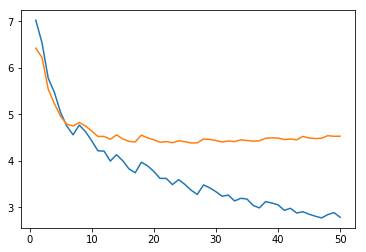

In [39]:
plot_loss(losses)

Ideas:
- Remove proper nouns (band names, song titles, places)?